# Algorithmic Trading

This project demonstrates the application of machine learning in predicting cryptocurrency price movements and developing an algorithmic trading strategy. The model achieves good accuracy in predicting price movements, and the backtested strategy provides insight into its performance. However, the strategy’s high volatility underscores the need for continuous refinement and risk management in real-world trading scenarios.

In [1]:
import numpy as np
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [2]:
# Load Data
zip_file_path = 'Cryptocurrency Historical Data.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current directory

data_path = 'consolidated_coin_data.csv'
df = pd.read_csv(data_path)

In [3]:
# Preprocess Data
df.Date = pd.to_datetime(df.Date)
df = df[::-1]  # Reverse the data to get chronological order

# Handle missing values in 'Close' column by converting it to numeric, coercing errors to NaN
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

# Handle missing values in Volume and Market Cap columns (if needed, convert to numeric)
df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)
df['Market Cap'] = df['Market Cap'].replace({',': ''}, regex=True).astype(float)

# Feature Engineering: Adding Daily Returns, Log Returns, and Moving Averages
df['Daily_Return'] = df.groupby('Currency')['Close'].pct_change()
df['Log_Daily_Return'] = np.log1p(df['Daily_Return'])  # Log return
df['MA_7'] = df.groupby('Currency')['Close'].transform(lambda x: x.rolling(window=7).mean())
df['MA_30'] = df.groupby('Currency')['Close'].transform(lambda x: x.rolling(window=30).mean())

# Drop rows with NaN values created during feature engineering
df = df.dropna(subset=['Daily_Return', 'Log_Daily_Return', 'MA_7', 'MA_30'])

# Add Lagged Features (for machine learning models to learn trends)
df['Lag_1'] = df.groupby('Currency')['Close'].shift(1)
df['Lag_2'] = df.groupby('Currency')['Close'].shift(2)

# Drop rows with NaN in lag columns
df = df.dropna()

# Select features and target
features = ['Log_Daily_Return', 'MA_7', 'Lag_1', 'Lag_2']  # MA_30 dropped due to high correlation
target = 'Close'  # Predicting the 'Close' price

# Normalize Data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert categorical variables into dummy variables (if needed)
df = pd.get_dummies(df, columns=['Currency'], drop_first=True)

# Define the target for classification (1: price increase, 0: price decrease)
df['Target'] = (df['Daily_Return'] > 0).astype(int)

# Drop rows with missing values in critical columns
df = df.dropna(subset=['Target', 'Log_Daily_Return', 'MA_7', 'Lag_1', 'Lag_2'])

# Prepare Data for Training (train/test split with TimeSeriesSplit for time-series data)
X = df[features]
y = df['Target']

Cross-validation scores: [0.99978041 0.9931928  0.99451032 1.         1.        ]
Mean cross-validation score: 1.00
Accuracy: 1.00


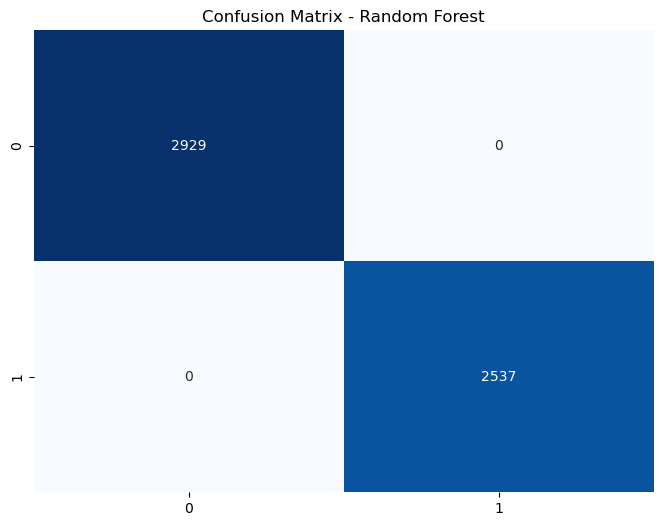

In [5]:
# TimeSeriesSplit for proper cross-validation on time-series data
tscv = TimeSeriesSplit(n_splits=5)
cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X, y, cv=tscv)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {np.mean(cross_val_scores):.2f}")

# Train Random Forest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Map the class weights to the corresponding class labels
sample_weights = y_train.map(lambda x: class_weights[x])

# Train the Random Forest model using the sample_weights
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.show()

Feature Importance:
                   Importance
Log_Daily_Return    0.983799
Lag_1               0.008104
Lag_2               0.004084
MA_7                0.004013
Trading Strategy Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      2929
           1       1.00      0.44      0.61      2537

    accuracy                           0.74      5466
   macro avg       0.84      0.72      0.71      5466
weighted avg       0.83      0.74      0.72      5466



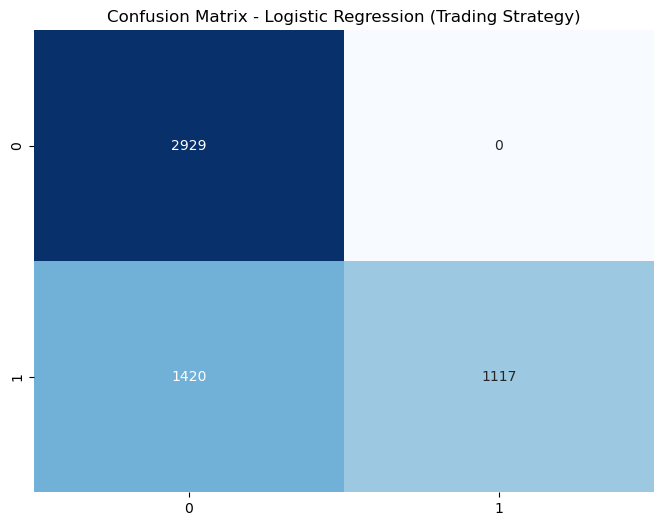

In [6]:
# Feature Importance
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame(importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False)
print("Feature Importance:\n", feature_importances)

# Trading Strategy: Predict Daily Price Movement (Buy/Sell)
df['Price_Movement'] = df['Daily_Return'].apply(lambda x: 1 if x > 0 else 0)  # 1 for 'Up' price movement, 0 for 'Down'

# Train Logistic Regression for Price Movement Prediction
X = df[features]
y = df['Price_Movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predict Price Movements
y_pred = log_reg.predict(X_test)

# Evaluation for Trading Strategy
accuracy = accuracy_score(y_test, y_pred)
print(f"Trading Strategy Accuracy: {accuracy:.2f}")

# Additional Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix for Trading Strategy
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Logistic Regression (Trading Strategy)')
plt.show()


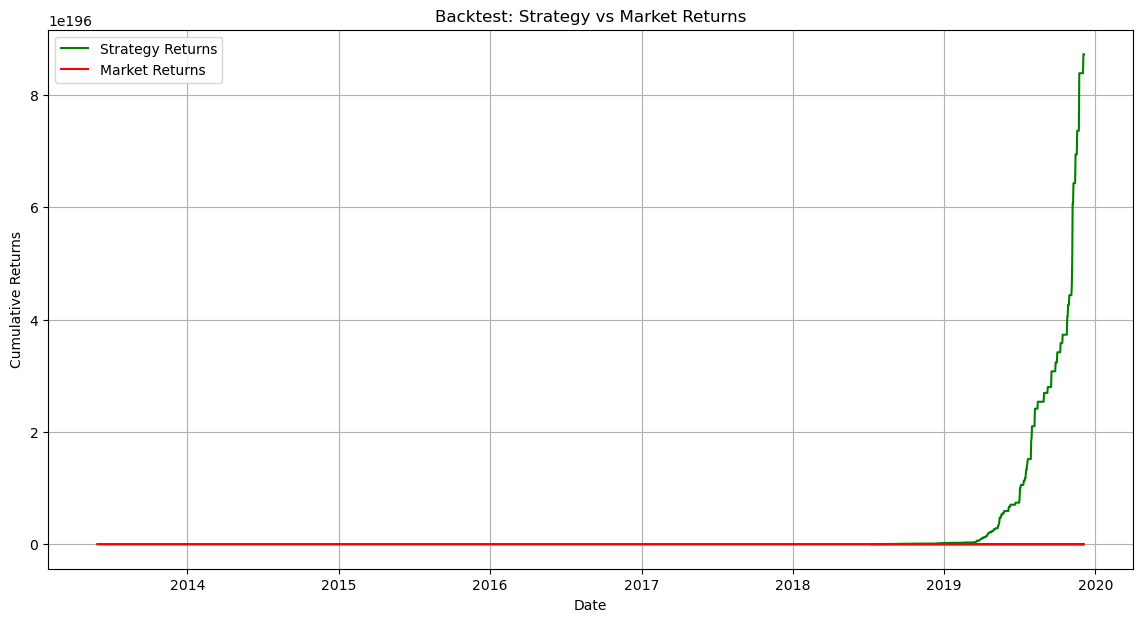

In [7]:
# Backtesting Strategy: Calculate Returns from Predictions
df['Predicted_Movement'] = log_reg.predict(X)
df['Strategy_Return'] = df['Predicted_Movement'] * df['Daily_Return']

# Plot Performance
cumulative_returns = (1 + df['Strategy_Return']).cumprod()
market_cumulative_returns = (1 + df['Daily_Return']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], cumulative_returns, label='Strategy Returns', color='g')
plt.plot(df['Date'], market_cumulative_returns, label='Market Returns', color='r')
plt.legend()
plt.title('Backtest: Strategy vs Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()


Sharpe Ratio: 0.02
Annualized Sharpe Ratio: 0.25
Total Return for Strategy: 8725046065205448702060445819442439973402490319596385441170975854531917046038852284805436871425431850252072259717103219883416474436752896351436041614195938068639692991163433774400683301445881540116480.00%
Total Return for Market: -100.00%
Maximum Drawdown for Strategy: -67.66%
Maximum Drawdown for Market: -100.00%


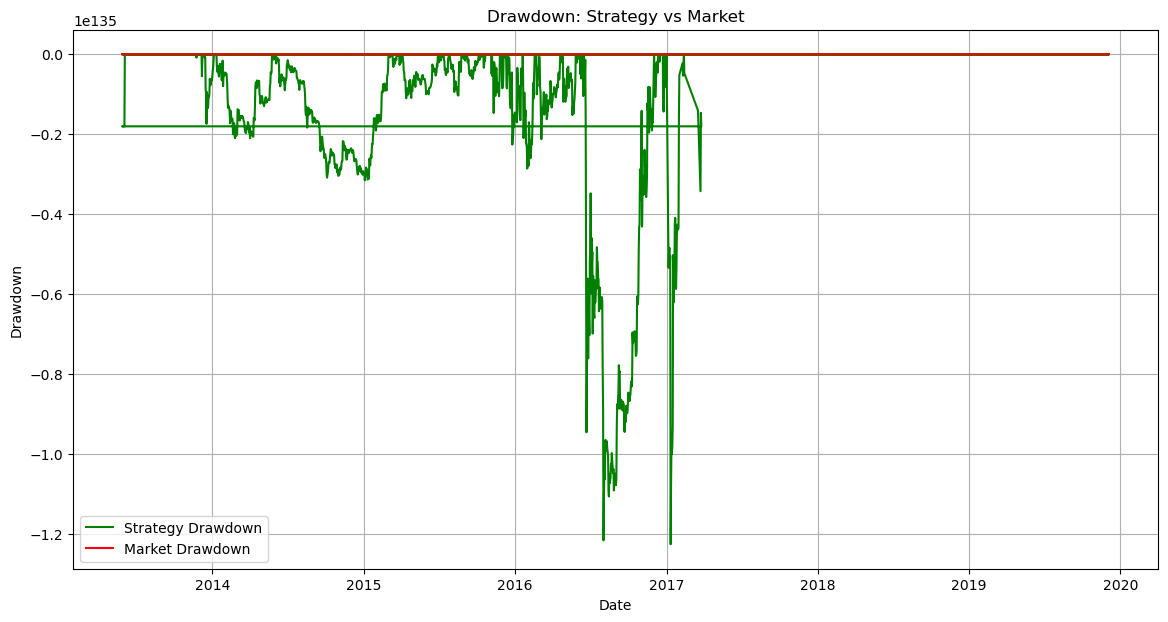

In [8]:
# Calculate Sharpe Ratio for the Strategy
sharpe_ratio = np.mean(df['Strategy_Return']) / np.std(df['Strategy_Return'])
sharpe_ratio_annualized = np.mean(df['Strategy_Return']) / np.std(df['Strategy_Return']) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized:.2f}")

# Calculate Total Return and Maximum Drawdown
total_return_strategy = cumulative_returns.iloc[-1] - 1  # Final cumulative return minus 1
total_return_market = market_cumulative_returns.iloc[-1] - 1  # Same for market returns

# Calculate Maximum Drawdown
def calculate_max_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    return drawdown.min()

max_drawdown_strategy = calculate_max_drawdown(cumulative_returns)
max_drawdown_market = calculate_max_drawdown(market_cumulative_returns)

# Display Results
print(f"Total Return for Strategy: {total_return_strategy * 100:.2f}%")
print(f"Total Return for Market: {total_return_market * 100:.2f}%")
print(f"Maximum Drawdown for Strategy: {max_drawdown_strategy * 100:.2f}%")
print(f"Maximum Drawdown for Market: {max_drawdown_market * 100:.2f}%")

# Plotting the drawdown for visualization (optional)
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], cumulative_returns - cumulative_returns.cummax(), label='Strategy Drawdown', color='g')
plt.plot(df['Date'], market_cumulative_returns - market_cumulative_returns.cummax(), label='Market Drawdown', color='r')
plt.legend()
plt.title('Drawdown: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()